In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
from sympy import sqrt, cos, sin,  cosh,  sinh, Add
from sympy import Symbol, S, oo, Rational, Function, pi , factorial, O, symbols, lambdify, I
from sympy import Derivative, series, limit, Matrix, simplify, collect, solve, Poly, poly, diff, nsolve, transpose, factor_terms
from sympy import latex, init_printing
from sympy.core.numbers import NegativeOne, One, Zero
from sympy.printing.latex import print_latex

import numpy as np
from tqdm import tqdm
import ray
import time

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import HamDrift6D, HamQuad6D
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.Utils.Plotting import multi_countour_plot
from acchamiltoniansandmatrices.Factorization.Factorization import truncate, taylorize, dragt_finn_factorization
from acchamiltoniansandmatrices.Utils.Polynomials import getpoly, RotationMatrix2D, explicitCheck, geteigenvects
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import RnpQuad6DChroma
from acchamiltoniansandmatrices.Matrices.SymbMatrices import RsymbQuad6DChroma
from acchamiltoniansandmatrices.Integrators import integrator

In [3]:
%matplotlib notebook
init_printing() 

In [4]:
x, px, y, py, z, delta = symbols('x p_x y p_y z delta', real=True)
eps, h , k0, k1, k2, sigma, betag = symbols('epsilon h k_0 k_1 k_2 sigma beta_gamma', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)
x0,px0 = symbols('x_0 px_0') # to not overwrite anything

# redefine for use in ringham - otherwise assumption errors
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")
dld   = symbols('\delta{L_D}') # delta length drift

In [5]:
# standardized substitutions that are useful - ORDER IN LISTS COUNTS !!!!
betagamma_rep = list(zip([beta0 * gamma0, beta0],[oo,1]))
series_rep    = list(zip([px,py,delta],[eps*px,eps*py,eps*delta]))
coord_rep     = list(zip([x,y],[eps*x,eps*y]))
thin_rep      = list(zip([px,py,delta],[0,0,0]))
xpx_rep       = list(zip([y,py,delta],[0,0,0]))
eps_rep       = list(zip([x,y,z,px,py,delta],[eps*x,eps*y,0,px*eps,py*eps,0]))
xyplane_rep   = list(zip([y,py,z,delta],[0,0,0,0]))
track_rep     = list(zip([x,px],[x0,px0]))
inv_track_rep = list(zip([x0,px0],[x,px]))

# Similarity transforms and BCH

In [6]:
x1,x2,p1,p2 = symbols("x_1 x_2 p_1 p_2")

In [7]:
H1 = LieOperator(p1**2+x1**2,[x1],[p1])
H2 = LieOperator(p2**2,[x2],[p2])

In [8]:
h1 = Function('h_1')(x1,p1)
h2 = Function('h_2')(x2,p2)

In [9]:
LieOperator(h1,[x1],[p1]) * LieOperator(h2,[x2],[p2])

TypeError: Lie Operators do not have the same dimension.

## Direct BCH

In [10]:
H1.LieMap(x1,6).ham,H1.LieMap(p1,6).ham

In [11]:
H2.LieMap(x2,6).ham,H2.LieMap(p2,6).ham

In [12]:
H1.BCH(H2,2)

TypeError: Lie Operators do not have the same dimension.

## Apply coordinate transform first

In [13]:
newH1 = H1.subs(x1,H2.LieMap(x2,6).ham).subs(p1,H2.LieMap(p2,6).ham).ham.expand()
newH1

In [16]:
LieOperator(newH1,[x2],[p2]).BCH(H2,5).doit().ham.expand()

# Apply to tracking case

In [104]:
# generic f2 as coefficients are not known
f2 = -Rational(1,2)*(x**2+px**2)
f2 = - Rational(1,2) * 20.7567366484553 * (0.00509225385783632*x**2 + px**2)
f4 = 15.342124163735 * px**4 -1.62004334948097 * px**3 * x + 0.115392952464151 * px**2 * x**2 -.00863758125104042 * px * x**3 + 0.000343540742321468 * x**4

In [123]:
f2

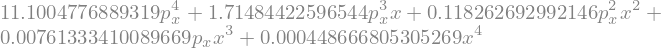

In [105]:
f4_tr = f4.subs(
    x, LieOperator(f2,[x],[px]).LieMap(x,10).ham.subs(x,x0).subs(px,px0)
).subs(
    px, LieOperator(f2,[x],[px]).LieMap(px,10).ham.subs(x,x0).subs(px,px0)
).expand().subs(inv_track_rep)

f4_tr.expand()

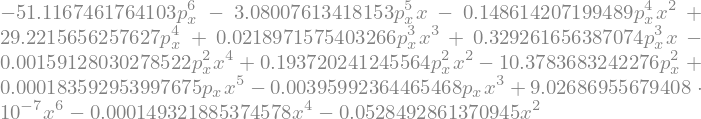

In [113]:
f4bch = LieOperator(f4,[x],[px]).BCH(LieOperator(f2,[x],[px]),4).doit().ham.expand()
f4bch

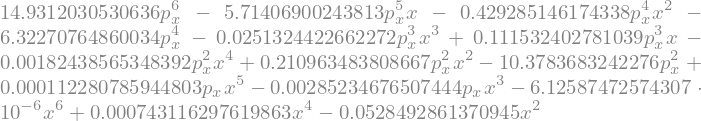

In [114]:
f4trbch = LieOperator(f4_tr,[x],[px]).BCH(LieOperator(f2,[x],[px]),4).doit().ham.expand()
f4trbch

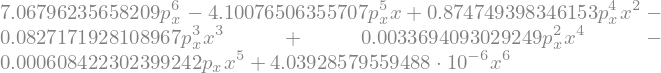

In [121]:
f6 = 7.06796235658209*px**6 -4.10076506355707* px**5 *x + 0.874749398346153*px**4*x**2-0.0827171928108967*px**3*x**3+0.0033694093029249*px**2*x**4-6.08422302399242*10e-5*px*x**5+4.03928579559488*10e-7*x**6
f6

<IPython.core.display.Javascript object>


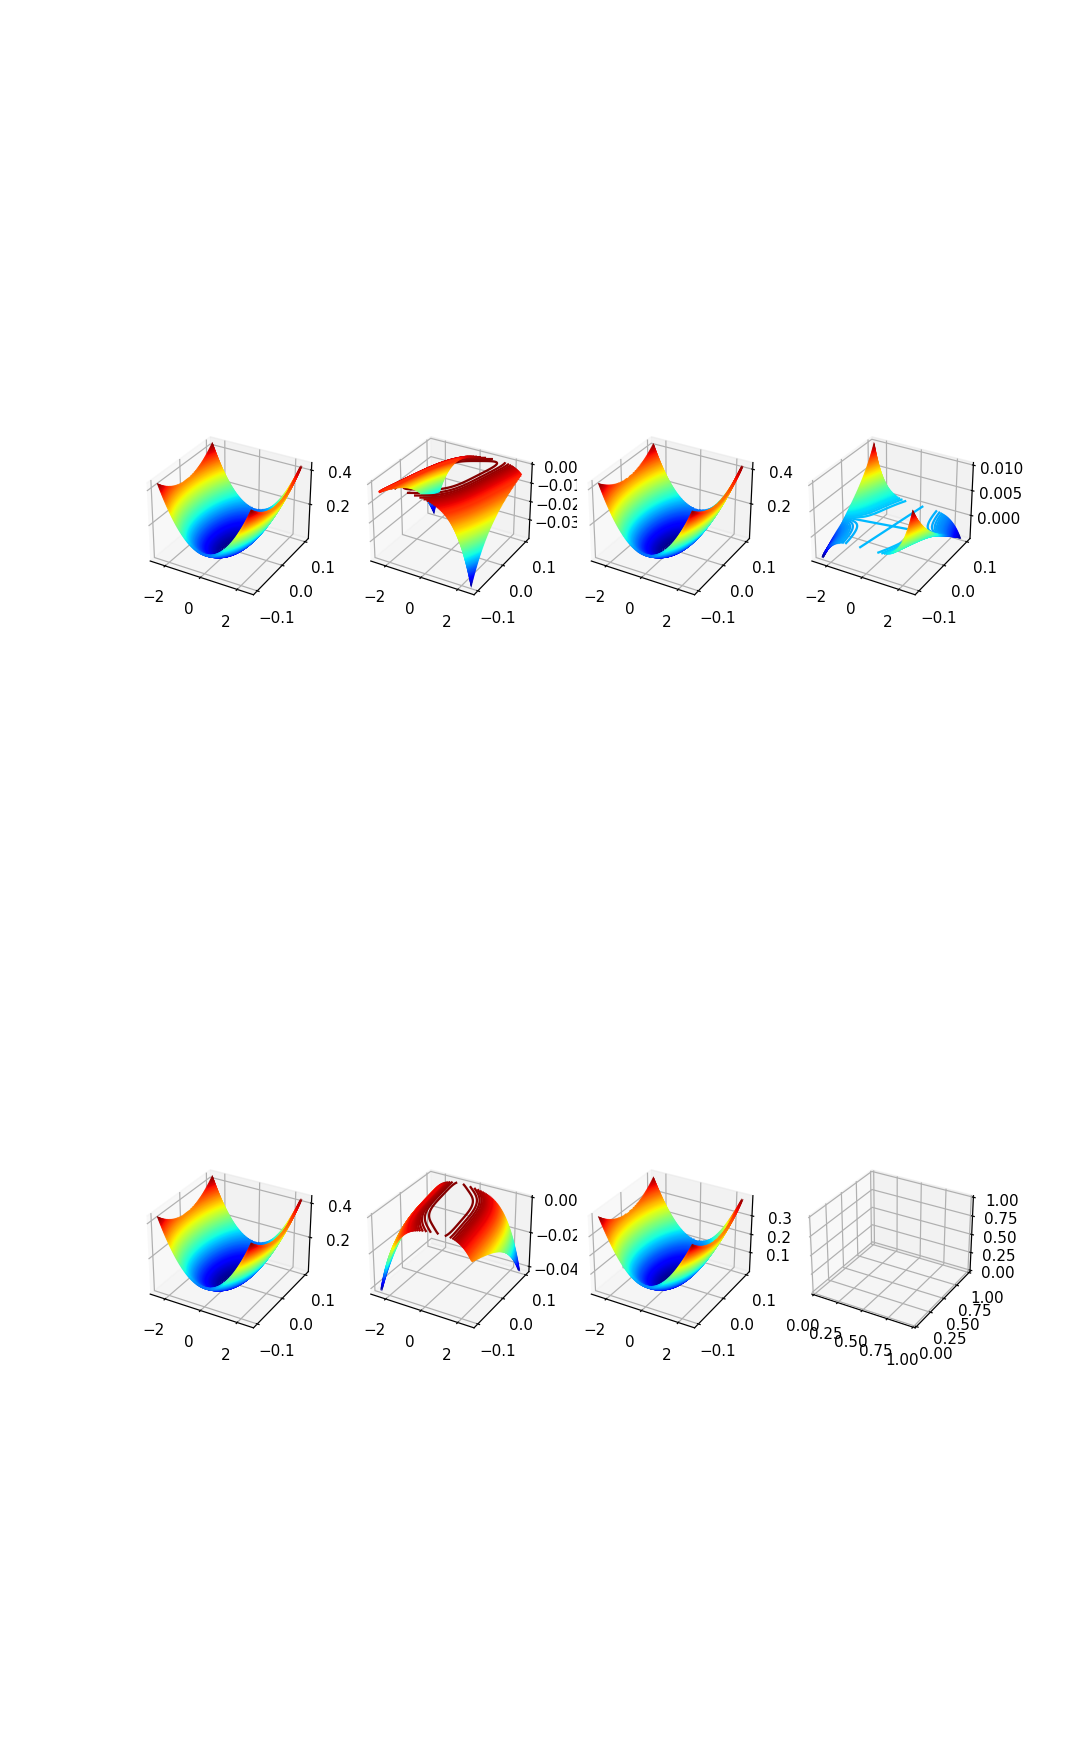

In [125]:
func2 = lambdify((x,px),-f2)  
func4 = lambdify((x,px),-f4)  
func4_tr = lambdify((x,px),-f4_tr)

func4bch = lambdify((x,px),-f4bch)  
func4_trbch = lambdify((x,px),-f4trbch)

func6 = lambdify((x,px),f6)

fig = plt.figure(figsize=(10,16))
gs = fig.add_gridspec(2, 4)
axes = [fig.add_subplot(gs[i, j], projection='3d') for j in range(4) for i in range(2)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 2.5
prange = .1
npoints= 500

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func2(Xg,Pg),func4(Xg,Pg), func4bch(Xg,Pg),func6(Xg,Pg),func2(Xg,Pg),func4_tr(Xg,Pg),func4_trbch(Xg,Pg)]

axes[0].contour(Xg, Pg, Hlist[0], levels=150,cmap=cm.jet)
axes[1].contour(Xg, Pg, Hlist[4], levels=150,cmap=cm.jet)
axes[2].contour(Xg, Pg, Hlist[1], levels=150,cmap=cm.jet)
axes[3].contour(Xg, Pg, Hlist[5], levels=150,cmap=cm.jet)
axes[4].contour(Xg, Pg, Hlist[2], levels=150,cmap=cm.jet)
axes[5].contour(Xg, Pg, Hlist[6], levels=150,cmap=cm.jet)
axes[6].contour(Xg, Pg, Hlist[3], levels=150,cmap=cm.jet)

# BCH

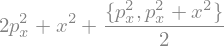

In [127]:
LieOperator(px**2,[x],[px]).BCH(LieOperator(x**2+px**2,[x],[px]),2).ham

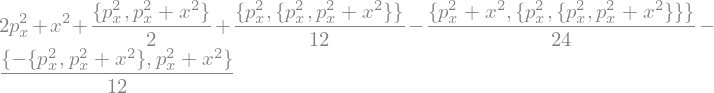

In [161]:
LieOperator(px**2,[x],[px]).BCH(LieOperator(x**2+px**2,[x],[px]),4).ham

In [129]:
LieOperator(px**2,[x],[px]).BCH(LieOperator(x**2+px**2,[x],[px]),2).ham.doit()

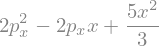

In [130]:
LieOperator(px**2,[x],[px]).BCH(LieOperator(x**2+px**2,[x],[px]),3).ham.doit()

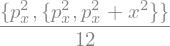

In [151]:
b1 = PoissonBracket(px**2,PoissonBracket(px**2,px**2+x**2,coords=[x],mom=[px]),coords=[x],mom=[px])/12
b1

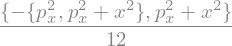

In [152]:
b2 = PoissonBracket(-PoissonBracket(px**2,px**2+x**2,coords=[x],mom=[px]),px**2+x**2,coords=[x],mom=[px])/12
b2

In [165]:
242

OSError: [Errno 12] Cannot allocate memory

242

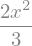

In [155]:
b1.doit()-b2.doit()

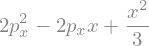

In [147]:
x**2+2*px**2+PoissonBracket(px**2,px**2+x**2,coords=[x],mom=[px]).doit()/2 + PoissonBracket(x**2,PoissonBracket(px**2,px**2+x**2,coords=[x],mom=[px]),coords=[x],mom=[px]).doit()/12

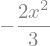

In [148]:
PoissonBracket(x**2,PoissonBracket(px**2,px**2+x**2,coords=[x],mom=[px]),coords=[x],mom=[px]).doit()/12

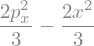

In [139]:
-PoissonBracket(PoissonBracket(px**2,px**2+x**2,coords=[x],mom=[px]).doit(),px**2+x**2,coords=[x],mom=[px]).doit()/12

In [142]:
PoissonBracket(PoissonBracket(px**2,px**2+x**2,coords=[x],mom=[px]),px**2+x**2,coords=[x],mom=[px])